# MNIST with SciKit-Learn and skorch

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [2]:
mnist = fetch_openml('mnist_784', cache=False)

In [3]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [4]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [5]:
X /= 255.0

In [6]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [9]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [10]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

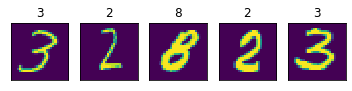

In [11]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [12]:
import torch
from torch import nn
import torch.nn.functional as F

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [14]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [15]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [16]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [17]:
from skorch import NeuralNetClassifier

/home/jvacher/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [18]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [19]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8297       0.8876        0.4013  1.1143
      2        0.4352       0.9121        0.3075  1.0319
      3        0.3653       0.9218        0.2698  0.9796
      4        0.3223       0.9312        0.2350  1.0698
      5        0.2953       0.9348        0.2216  1.0378
      6        0.2705       0.9409        0.2006  1.0574
      7        0.2575       0.9439        0.1872  1.0025
      8        0.2443       0.9466        0.1796  1.0236
      9        0.2315       0.9509        0.1673  1.0262
     10        0.2245       0.9533        0.1618  1.1296
     11        0.2124       0.9543        0.1550  1.0328
     12        0.2086       0.9559        0.1503  1.3445
     13        0.2011       0.9584        0.1446  1.1056
     14        0.1969       0.9582        0.1399  1.0601
     15        0.1911       0.9591        0.1369  1.0654
     16        0.1828       0.9

## Prediction

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
y_pred = net.predict(X_test)

In [22]:
accuracy_score(y_test, y_pred)

0.9624

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [23]:
error_mask = y_pred != y_test

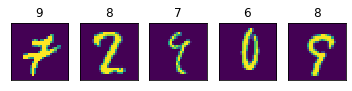

In [24]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

In [25]:
XCnn = X.reshape(-1, 1, 28, 28)

In [26]:
XCnn.shape

(70000, 1, 28, 28)

In [27]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [28]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [29]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [30]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [31]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4323       0.9705        0.0956  2.0726
      2        0.1706       0.9786        0.0673  2.1214
      3        0.1351       0.9809        0.0613  2.1463
      4        0.1134       0.9853        0.0484  1.6721
      5        0.1066       0.9864        0.0462  1.7096
      6        0.0979       0.9871        0.0442  1.7887
      7        0.0904       0.9870        0.0397  1.8350
      8        0.0826       0.9881        0.0390  1.8292
      9        0.0811       0.9891        0.0356  1.9749
     10        0.0744       0.9879        0.0381  2.1215


In [32]:
y_pred_cnn = cnn.predict(XCnn_test)

In [33]:
accuracy_score(y_test, y_pred_cnn)

0.988

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [34]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7598784194528876

Over 70% of the previously misclassified images are now correctly identified.

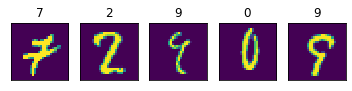

In [35]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])